# Ex 1.2: A simple parallel MapReduce framework in Python
Now we use the [*multiprocessing*](https://docs.python.org/3/library/multiprocessing.html) lib to actually do things in parallel

In [4]:
import collections
import itertools
import multiprocessing


class SimpleMapReduce:

    def __init__(self, map_func, reduce_func, num_workers=None):
        """
        map_func

          Function to map inputs to intermediate data. Takes as
          argument one input value and returns a tuple with the
          key and a value to be reduced.

        reduce_func

          Function to reduce partitioned version of intermediate
          data to final output. Takes as argument a key as
          produced by map_func and a sequence of the values
          associated with that key.

        num_workers

          The number of workers to create in the pool. Defaults
          to the number of CPUs available on the current host.
        """
        self.map_func = map_func
        self.reduce_func = reduce_func
        self.pool = multiprocessing.Pool(num_workers)

    def partition(self, mapped_values):
        """Organize the mapped values by their key.
        Returns an unsorted sequence of tuples with a key
        and a sequence of values.
        """
        partitioned_data = collections.defaultdict(list)
        for key, value in mapped_values:
            partitioned_data[key].append(value)
        return partitioned_data.items()

    def __call__(self, inputs, chunksize=1):
        """Process the inputs through the map and reduce functions
        given.

        inputs
          An iterable containing the input data to be processed.

        chunksize=1
          The portion of the input data to hand to each worker.
          This can be used to tune performance during the mapping
          phase.
        """
        map_responses = self.pool.map(
            self.map_func,
            inputs,
            chunksize=chunksize,
        )
        partitioned_data = self.partition(
            itertools.chain(*map_responses)
        )
        reduced_values = self.pool.map(
            self.reduce_func,
            partitioned_data,
        )
        return reduced_values

### A Word Count example

In [5]:
import string

# map - read file and count words
def file_to_words(filename):
    """Read a file and return a sequence of
    (word, occurences) values.
    """
    STOP_WORDS = set([
        'a', 'an', 'and', 'are', 'as', 'be', 'by', 'for', 'if',
        'in', 'is', 'it', 'of', 'or', 'py', 'rst', 'that', 'the',
        'to', 'with',
    ])
    TR = str.maketrans({
        p: ' '
        for p in string.punctuation
    })

    print('{} reading {}'.format(
        multiprocessing.current_process().name, filename))
    output = []

    with open(filename, 'rt') as f:
        for line in f:
            # Skip comment lines.
            if line.lstrip().startswith('..'):
                continue
            line = line.translate(TR)  # Strip punctuation
            for word in line.split():
                word = word.lower()
                if word.isalpha() and word not in STOP_WORDS:
                    output.append((word, 1))
    return output

# reduce
def count_words(item):
    """Convert the partitioned data for a word to a
    tuple containing the word and the number of occurences.
    """
    word, occurences = item
    return (word, sum(occurences))

In [6]:
import operator
import glob #easy file access

input_files = glob.glob('*.rst')#get all text files names 

mapper = SimpleMapReduce(file_to_words, count_words)#get mapreduce instance with custom map and reduce functions
word_counts = mapper(input_files)#call parallel mapreduce on files

word_counts.sort(key=operator.itemgetter(1))#sort results
word_counts.reverse()

print('\nTOP 20 WORDS BY FREQUENCY\n')
top20 = word_counts[:20]
longest = max(len(word) for word, count in top20)
for word, count in top20:
    print('{word:<{len}}: {count:5}'.format(
            len=longest + 1,
            word=word,
            count=count)
    )

ForkPoolWorker-3 reading text2.rst
ForkPoolWorker-4 reading text3.rst
ForkPoolWorker-3 reading text4.rst
ForkPoolWorker-3 reading text1.rst

TOP 20 WORDS BY FREQUENCY

my    :    67
i     :    60
her   :    43
he    :    41
quiz  :    33
quick :    28
was   :    28
his   :    23
fox   :    22
she   :    21
from  :    20
when  :    20
blind :    19
have  :    18
vex   :    18
would :    18
but   :    18
so    :    18
on    :    17
there :    16


## K-Means implementation
Use the simple frame work to implement K-Means

In [7]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

array([[-3.46545605,  8.74930881],
       [-5.64311725,  8.47604128],
       [-6.30942079,  4.68012111],
       ...,
       [-7.83949117,  7.06991784],
       [-6.2442887 ,  5.61979359],
       [ 2.10381688,  6.14622467]])

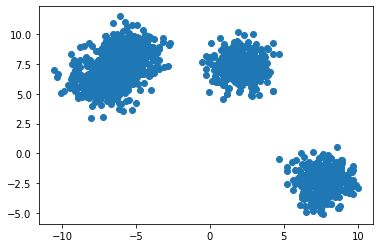

In [16]:
#generate data with K=4
X, y = make_blobs(n_samples=1500, centers=4)
plt.scatter(X[:, 0], X[:, 1])
X

CPU times: user 52.7 ms, sys: 2.25 ms, total: 54.9 ms
Wall time: 57.3 ms


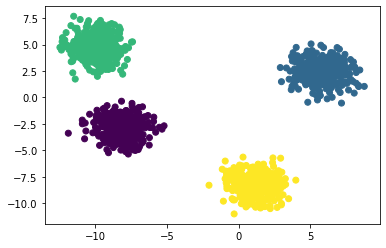

In [15]:
%%time
#K-Means ref implementation
k = KMeans(n_clusters=4)
y_pred = k.fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_pred)

In [ ]:
k.cluster_centers_

array([[-9.99249643, -3.96847878],
       [ 4.46390788,  4.52830799],
       [-0.48955215,  6.7685505 ],
       [-6.07098139, -2.91811314]])

##Kmeans implementation with MapReduce

Mapper Function

//Map function find nearest centers to the coordinates

Map Phase input:<k1, v1>

k1- line number

v1- point(coordinates)

//Find minimum center from point

For each center

Find minimum distance to point

End for

k2-nearest center

V2-point

Output: <k2,v2>

Reducer Function

//Compute new cluster centers

Reduce Phase input:<k2, List<v2>>

Calculate mean value for v2 points

new center point-mean value

k3-new center point

v3-points

Output: <k3,v3>

Continue the process till the clusters are converged.

In [ ]:
#implement map -> assign data to center 
def kMap(data,center): 


SyntaxError: invalid syntax (<ipython-input-11-07f67536fcec>, line 2)

In [ ]:
#implement reduce -> compute new centers
def kReduce(new_point,centers):
  return new_center


In [ ]:
#init centers
center = X[np.random.randint(X.shape[0], size=4), :]#get 4 random datapoints
print('init center', center)

init center [[-7.43559786 -2.53818871]
 [-9.68259007 -2.75656783]
 [-9.92905839 -2.02917772]
 [ 5.88128798  8.58245137]]


In [ ]:
#use framework
mapper = SimpleMapReduce(kMap, kReduce)#get mapreduce instance with custom map and reduce functions
center = mapper(X)#call parallel mapreduce oo data

NameError: name 'kMap' is not defined